<a href="https://colab.research.google.com/github/ArjunNarayan2066/CS484_project/blob/main/cs484_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Self-supervised depth estimation consists on training a neural network to provide dense pixel-wise depth predictions given a single image. "Self-supervision"  in the training process implies not relying on ground truth depth maps, which can be hard and expensive to acquire. This project is motivated by Digging Into Self-Supervised Monocular Depth Estimation [1].

The network attempts to generate a synthetic view of the same scene from a different point of view. This implicitly generated a disparity map, if per-pixel correspondences are known. The relative pose of the virtual viewpoint with respect to the actual viewpoint (i.e. real camera) is represented as $T_{t' \rightarrow t}$, and the synthetic image is denoted $I_{t'}$, given an original image $I_t$.

The loss functions employed in the training are as follows. 
$$L_p = \Sigma_{t'} pe( I_{t}, I_{t'\rightarrow t})$$

where $pe$ represents the $L1$ distance between matching pixels in pixel space and is defined as:

$$pe(I_a, I_b) = \frac{\alpha}{2}(1-SSIM(I_a, I_b)) + (1-\alpha) ||I_a - I_b||_1$$

$\alpha$ is set to 0.85.

$SSIM$ represents structural similarity between images $I_a$ and $I_b$. That is, the sum of x and y distances for all matches:

$$SSIM(x, y) = \frac{(2\mu_x\mu_y+c_1)(2\sigma_{xy}+c_2)}{(\mu_x^2+\mu_y^2+c_1)(\sigma_x^2+\sigma_y^2+c_2)}$$

$I_{t'\rightarrow t}$ is defined as follows:

$$I_{t'\rightarrow t} = I_{t'}\langle proj(D_t, T_{t\rightarrow t'}, K)\rangle$$

for $D_t$ being projected depths, $\langle . \rangle$ being the sampling operator.

Note that the $pe$ function provides a weighted sum of visually perceptible differences between images (SSIM), and the L1 norm between said images, as described in [2].




In [2]:
! nvcc --version

! pip install tensorboardX==1.4
! pip install opencv-python==3.3.1.11
! pip install kornia

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
     |████████████████████████████████| 71kB 3.9MB/s 
     |████████████████████████████████| 24.7MB 1.9MB/s 
ERROR: dopamine-rl 1.0.5 has requirement opencv-python>=3.4.1.15, but you'll have opencv-python 3.3.1.11 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 225kB 6.4MB/s 


In [3]:
# Clone repo
# ! rm -rf monodepth2
! git clone https://github.com/ArjunNarayan2066/monodepth2.git

Cloning into 'monodepth2'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 193 (delta 18), reused 31 (delta 12), pack-reused 150
Receiving objects: 100% (193/193), 10.98 MiB | 27.30 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [4]:
%matplotlib notebook

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
from PIL import Image
import kornia

import torch
from torchvision import transforms


In [6]:
class SSIM(torch.nn.Module):
    def __init__(self):
        super(SSIM, self).__init__()
        self.mu_x_pool   = nn.AvgPool2d(3, 1)
        self.mu_y_pool   = nn.AvgPool2d(3, 1)
        self.sig_x_pool  = nn.AvgPool2d(3, 1)
        self.sig_y_pool  = nn.AvgPool2d(3, 1)
        self.sig_xy_pool = nn.AvgPool2d(3, 1)

        self.refl = nn.ReflectionPad2d(1)

        self.C1 = 0.01 ** 2
        self.C2 = 0.03 ** 2

    def forward(self, x, y):
        x = self.refl(x)
        y = self.refl(y)

        mu_x = self.mu_x_pool(x)
        mu_y = self.mu_y_pool(y)

        sigma_x  = self.sig_x_pool(x ** 2) - mu_x ** 2
        sigma_y  = self.sig_y_pool(y ** 2) - mu_y ** 2
        sigma_xy = self.sig_xy_pool(x * y) - mu_x * mu_y

        SSIM_n = (2 * mu_x * mu_y + self.C1) * (2 * sigma_xy + self.C2)
        SSIM_d = (mu_x ** 2 + mu_y ** 2 + self.C1) * (sigma_x + sigma_y + self.C2)

        return torch.clamp((1 - SSIM_n / SSIM_d) / 2, 0, 1)


In [ ]:
! wget -i monodepth2/splits/kitti_archives_to_download.txt -P kitti_data/

! unzip -o "kitti_data/*.zip" -d "kitti_data/"

# Convert to jpg
! sudo apt update
! sudo apt install imagemagick
! sudo apt install parallel
! find kitti_data/ -name '*.png' | parallel 'convert -quality 92 -sampling-factor 2x2,1x1,1x1 {.}.png {.}.jpg && rm {}'


Generate a list of all the downloaded files, append $l$ or $r$ corresponding to which one of the cameras in the stereo pair it was taken on.


In [ ]:
! find kitti_data/ -type f -name '*.jpg' >> all_files.txt

In [ ]:
fp = open('./all_files.txt', 'r')
all_lines = fp.readlines()
all_lines = [x.strip() for x in all_lines]


##########################################################
fp2 = open('monodepth2/splits/eigen_all_files.txt', 'r')
eigen_lines = fp2.readlines()
eigen_lines = [x.strip() for x in eigen_lines]

output_file = open("output_files_train.txt", "w")


eigen_dict = {}

for line in eigen_lines:
    # print(line.split(' '))
    filepath, number, RL = line.split(' ')
    number = str(int(number))

    key = ' '.join([filepath, number])

    eigen_dict[key] = RL

for i, _ in enumerate(all_lines):
    first_part = '/'.join( all_lines[i].split('/')[2:-3] )
    second_part = str(int(all_lines[i].split('/')[-1].split('.')[0])) #remove trailing zeros

    joined = ' '.join([first_part, second_part])
    
    if joined in eigen_dict:
        output_file.write(' '.join([joined, eigen_dict[joined]]))
        output_file.write('\n')

output_file.close()


In [ ]:
import torch
! uname -a
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

In [ ]:
! rm -rf kitti_data

In [11]:
# ! wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_calib.zip
# ! wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0001/2011_09_28_drive_0001_sync.zip
# ! wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0002/2011_09_28_drive_0002_sync.zip

! wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
! wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0042/2011_10_03_drive_0042_sync.zip
! wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

# ! wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
# ! wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0091/2011_09_26_drive_0091_sync.zip


--2020-12-18 16:06:29--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.74.56
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.74.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2020-12-18 16:06:29 (196 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]

--2020-12-18 16:06:29--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0042/2011_10_03_drive_0042_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.74.56
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.74.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4239391956 (3.9G) [application/zip]
Sav

In [12]:
# ! rm -rf kitti_data
# ! mkdir kitti_data

# ! unzip -q 2011_09_28_calib.zip -d kitti_data
# ! rm -rf 2011_09_28_calib.zip
# ! unzip -q 2011_09_28_drive_0001_sync.zip -d kitti_data
# ! rm -rf 2011_09_28_drive_0001_sync.zip
# ! unzip -q 2011_09_28_drive_0002_sync.zip -d kitti_data
# ! rm -rf 2011_09_28_drive_0002_sync.zip

! unzip -q 2011_10_03_calib.zip -d kitti_data
! rm -rf 2011_10_03_calib.zip
! unzip -q 2011_10_03_drive_0042_sync.zip -d kitti_data
! rm -rf 2011_10_03_drive_0042_sync.zip
! unzip -q 2011_10_03_drive_0047_sync.zip -d kitti_data
! rm -rf 2011_10_03_drive_0047_sync.zip

# ! unzip -q 2011_09_26_calib.zip -d kitti_data
# ! rm -rf 2011_09_26_calib.zip
# ! unzip -q 2011_09_26_drive_0091_sync.zip -d kitti_data
# ! rm -rf 2011_09_26_drive_0091_sync.zip


In [13]:
! sudo apt update
! sudo apt install imagemagick --fix-missing
! find kitti_data/ -name '*.png'
! sudo apt install parallel
! find kitti_data -name '*.png' | parallel 'convert -quality 92 -sampling-factor 2x2,1x1,1x1 {.}.png {.}.jpg && rm {}'

Streaming output truncated to the last 5000 lines.
kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_02/data/0000000807.png
kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_02/data/0000000061.png
kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_02/data/0000000032.png
kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_02/data/0000000090.png
kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_02/data/0000000639.png
kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_02/data/0000000595.png
kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_02/data/0000000494.png
kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_02/data/0000000593.png
kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_02/data/0000000237.png
kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_02/data/0000000339.png
kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_02/data/0000000521.png
kitti_data/2011_10_03/2011_10_03_drive_0047_sync/image_02/data/0000000659.png
kitti_data/20

In [ ]:
# ! python monodepth2/train.py --model_name S_640x192 --frame_ids 0 --use_stereo --pose_model_type separate_resnet --split eigen_full --data_path /content/kitti_data --num_epochs 10
# /content/kitti_data/2011_09_26/2011_09_26_drive_0106_sync/image_02/data/0000000115.png

In [ ]:
# ! zip -q -r /content/model.zip /root/tmp/S_640x192/*
# ! ls -la /root/tmp/S_640x192/models/

In [ ]:
# ! python monodepth2/export_gt_depth.py --data_path kitti_data --split eigen

In [ ]:
# ! python monodepth2/evaluate_depth.py --data_path kitti_data --load_weights_folder /root/tmp/S_640x192/models/weights_19/ --eval_stereo

In [40]:

import numpy as np
import torch
import torch.nn as nn

from collections import OrderedDict
import monodepth2.layers

class DepthDecoder(nn.Module):
    def __init__(self, num_ch_enc, num_channels_out=1):
        super(DepthDecoder, self).__init__()

        self.num_channels_out = num_channels_out
        self.scales = [0,1,2,3]

        self.num_ch_enc = num_ch_enc
        self.num_ch_dec = np.array([16, 32, 64, 128, 256])

        # decoder   
        self.convs = OrderedDict()

        ### 4 ###
        # upconv_0
        num_ch_in = self.num_ch_enc[-1]
        num_ch_out = self.num_ch_dec[4]
        self.convs[("upconv", 4, 0)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        # upconv_1
        num_ch_in = self.num_ch_dec[4]
        #skip connection
        num_ch_in += self.num_ch_enc[3]
        num_ch_out = self.num_ch_dec[4]
        self.convs[("upconv", 4, 1)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        ### 3 ###
        # upconv_0
        num_ch_in = self.num_ch_dec[4]
        num_ch_out = self.num_ch_dec[3]
        self.convs[("upconv", 3, 0)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        # upconv_1
        num_ch_in = self.num_ch_dec[3]
        #skip connection
        num_ch_in += self.num_ch_enc[2]
        num_ch_out = self.num_ch_dec[3]
        self.convs[("upconv", 3, 1)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        ### 2 ###
        # upconv_0
        num_ch_in = self.num_ch_dec[3]
        num_ch_out = self.num_ch_dec[2]
        self.convs[("upconv", 2, 0)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        # upconv_1
        num_ch_in = self.num_ch_dec[2]
        #skip connection
        num_ch_in += self.num_ch_enc[1]
        num_ch_out = self.num_ch_dec[2]
        self.convs[("upconv", 2, 1)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        ### 1 ###
        # upconv_0
        num_ch_in = self.num_ch_dec[2]
        num_ch_out = self.num_ch_dec[1]
        self.convs[("upconv", 1, 0)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        # upconv_1
        num_ch_in = self.num_ch_dec[1]
        #skip connection
        num_ch_in += self.num_ch_enc[0]
        num_ch_out = self.num_ch_dec[1]
        self.convs[("upconv", 1, 1)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        ### 0 ###
        # upconv_0
        num_ch_in = self.num_ch_dec[1]
        num_ch_out = self.num_ch_dec[0]
        self.convs[("upconv", 0, 0)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        # upconv_1
        num_ch_in = self.num_ch_dec[0]
        # No skip connection on the last layer
        num_ch_out = self.num_ch_dec[0]
        self.convs[("upconv", 0, 1)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        for s in self.scales:
            self.convs[("dispconv", s)] = monodepth2.layers.Conv3x3(self.num_ch_dec[s], self.num_channels_out)

        self.decoder = nn.ModuleList(list(self.convs.values()))
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        self.outputs = {}

        x = input_features[-1]

        ### 4 ###
        x = self.convs[("upconv", 4, 0)](x)
        x = [upsample(x)]
        x += [input_features[3]]
        x = torch.cat(x, 1)
        x = self.convs[("upconv", 4, 1)](x)

        ### 3 ###
        x = self.convs[("upconv", 3, 0)](x)
        x = [upsample(x)]
        x += [input_features[2]]
        x = torch.cat(x, 1)
        x = self.convs[("upconv", 3, 1)](x)
        self.outputs[("disp", 3)] = self.sigmoid(self.convs[("dispconv", 3)](x))

        ### 2 ###
        x = self.convs[("upconv", 2, 0)](x)
        x = [upsample(x)]
        x += [input_features[1]]
        x = torch.cat(x, 1)
        x = self.convs[("upconv", 2, 1)](x)
        self.outputs[("disp", 2)] = self.sigmoid(self.convs[("dispconv", 2)](x))

        ### 1 ###
        x = self.convs[("upconv", 1, 0)](x)
        x = [upsample(x)]
        x += [input_features[0]]
        x = torch.cat(x, 1)
        x = self.convs[("upconv", 1, 1)](x)
        self.outputs[("disp", 1)] = self.sigmoid(self.convs[("dispconv", 1)](x))

        ### 0 ###
        x = self.convs[("upconv", 0, 0)](x)
        x = [upsample(x)]
        x = torch.cat(x, 1)
        x = self.convs[("upconv", 0, 1)](x)
        self.outputs[("disp", 0)] = self.sigmoid(self.convs[("dispconv", 0)](x))

        return self.outputs

## Compute gradient of image to give Loss function different weights

In [41]:
def get_gradient(t, device, gauss_blur_sigma=None, kernel_size = 5):
  a = torch.Tensor([[1, 0, -1],
  [2, 0, -2],
  [1, 0, -1]]).to(device)

  a = a.view((1,1,3,3))
  G_x = F.conv2d(t, a, padding=1)

  b = torch.Tensor([[1, 2, 1],
  [0, 0, 0],
  [-1, -2, -1]]).to(device)

  b = b.view((1,1,3,3))
  G_y = F.conv2d(t, b, padding=1)

  G = torch.sqrt(torch.pow(G_x,2)+ torch.pow(G_y,2))


  if gauss_blur_sigma:
    G = kornia.gaussian_blur2d(G, (kernel_size, kernel_size), (gauss_blur_sigma, gauss_blur_sigma))

  G -= torch.min(G)
  G /= torch.max(G)


  return G

### Testing the gradient function:

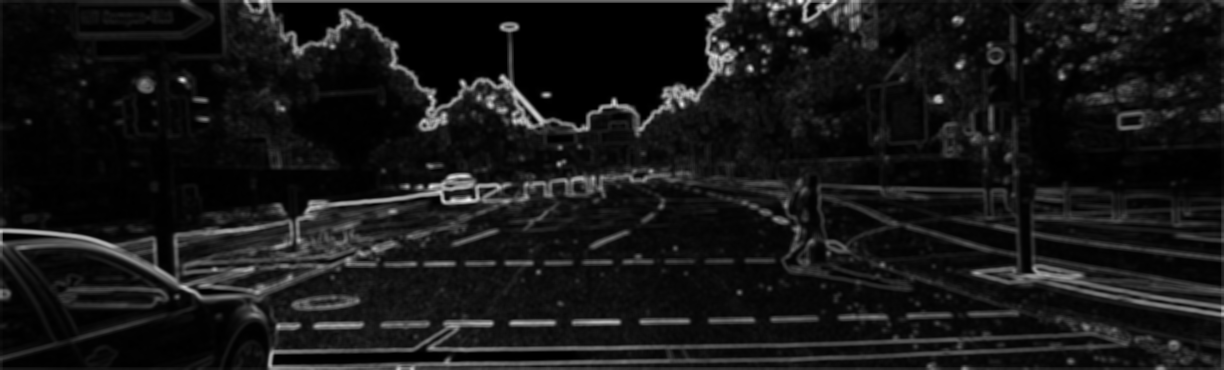

In [42]:

# Read in image
from PIL import Image
im = Image.open("./kitti_data/2011_09_28/2011_09_28_drive_0002_sync/image_00/data/0000000172.jpg")

# Convert to tensor and compute gradient
t = transforms.ToTensor()
t_im = t(im)[None]
t_im.shape
grad = get_gradient(t_im, torch.device("cpu"), gauss_blur_sigma=2)


t2 = transforms.ToPILImage()
g = t2(grad[0])

g


In [43]:
import os
import torchvision.models as models

def save_model(train):
    """Save model weights to disk
    """
    save_folder = os.path.join("/content/test_model/")
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    for model_name, model in train.models.items():
        save_path = os.path.join(save_folder, "{}.pth".format(model_name))
        to_save = model.state_dict()
        if 'encoder' in model_name:
            # save the sizes - these are needed at prediction time
            to_save['height'] = train.h
            to_save['width'] = train.w
            to_save['use_stereo'] = True
        torch.save(to_save, save_path)

    with open(os.path.join(save_folder, 'losses.txt'), 'w') as f:
        f.writelines("%s\n" % loss for loss in train.losses)

    save_path = os.path.join(save_folder, "{}.pth".format("adam"))
    torch.save(train.adam_optim.state_dict(), save_path)

In [51]:
###
###
### Training code is based on a very-stripped down version of https://arxiv.org/pdf/1806.01260.pdf
### Written only with stereo based training with reduced feature set
###
###


import monodepth2.layers, monodepth2.utils, monodepth2.trainer
import monodepth2.networks

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import timeit
import PIL.Image as pil


class MyTraining(object):
    def __init__(self, batch, epoch, weight_by_gradient=True):
        self.batch = batch
        self.epoch_max = epoch
        self.h = 192
        self.w = 640
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        # For listing which frames to check
        # For simple stereo is only current (0) and estimated pair (s)
        self.frames = [0, 's']

        # For multi-scale estimation
        self.loss_scales = [0, 1, 2, 3]

        # Weighting for loss function
        self.alpha = 0.85

        # Weighting for loss at high-contrast regions
        self.weight_by_gradient = weight_by_gradient
        self.beta = 0.1 

        # Define projections for pose estimation
        self.depth_projection = {}
        self.projection_3d = {}
        for loss_scale in self.loss_scales:
            h = int(self.h / (2 ** loss_scale))
            w = int(self.w / (2 ** loss_scale))

            self.depth_projection[loss_scale] = monodepth2.layers.BackprojectDepth(self.batch, h, w).to(self.device)
            self.projection_3d[loss_scale] = monodepth2.layers.Project3D(self.batch, h, w).to(self.device)
        
        ## Declare Depth Network
        self.depth_encoder_network = monodepth2.networks.ResnetEncoder(18, True).to(self.device)
        self.depth_decoder_network = DepthDecoder(self.depth_encoder_network.num_ch_enc).to(self.device) 
        # self.depth_decoder_network = monodepth2.networks.DepthDecoder(self.depth_encoder_network.num_ch_enc, 
        #                                         [0, 1, 2, 3]).to(self.device) 

        ## Declare Pose Network
        self.pose_encoder_network = monodepth2.networks.ResnetEncoder(18, True, num_input_images=2).to(self.device)
        self.pose_decoder_network = monodepth2.networks.PoseDecoder(self.pose_encoder_network.num_ch_enc, 
                                                num_input_features=1, num_frames_to_predict_for=2).to(self.device)

        self.models = {"encoder": self.depth_encoder_network, "depth": self.depth_decoder_network,
                       "pose_encoder": self.pose_encoder_network, "pose": self.pose_decoder_network}

        # Set up our excerpt of Kitti Dataset
        training_files = monodepth2.utils.readlines("/content/monodepth2/splits/eigen_full/train_files.txt")
        validation_files = monodepth2.utils.readlines("/content/monodepth2/splits/eigen_full/val_files.txt")

        print(" -- Training Size: {} --".format(len(training_files)))

        train_set = monodepth2.datasets.kitti_dataset.KITTIRAWDataset("/content/kitti_data", training_files, self.h, self.w, self.frames, 4, is_train=True, img_ext='.jpg')
        self.train_loader = DataLoader(train_set, self.batch, True, num_workers=6, pin_memory=True, drop_last=True)
        val_set = monodepth2.datasets.kitti_dataset.KITTIRAWDataset("/content/kitti_data", validation_files, self.h, self.w, self.frames, 4, is_train=False, img_ext='.jpg')
        self.val_loader = DataLoader(val_set, self.batch, True, num_workers=6, pin_memory=True, drop_last=True)

    def run_training_loop(self):
        self.all_params = list(self.depth_encoder_network.parameters())
        self.all_params += list(self.depth_decoder_network.parameters())
        self.all_params += list(self.pose_encoder_network.parameters())
        self.all_params += list(self.pose_decoder_network.parameters())

        # Same learning rate configuration as https://arxiv.org/pdf/1806.01260.pdf
        self.adam_optim = optim.Adam(self.all_params, 1e-4)
        self.lr_sched = optim.lr_scheduler.StepLR(self.adam_optim, 15, 0.1)
        self.ssim_loss_func = monodepth2.layers.SSIM().to(self.device)

        self.epoch_count = 0
        self.losses  = []

        epoch_start = timeit.default_timer()

        for self.epoch_count in range(self.epoch_max):
            # Per Epoch
            self.lr_sched.step()
            self.depth_encoder_network.train()
            self.depth_decoder_network.train()
            self.pose_encoder_network.train()
            self.pose_decoder_network.train()

            for idx, inputs in enumerate(self.train_loader):
                # Push to GPU
                for key, ipt in inputs.items():
                    inputs[key] = ipt.to(self.device)

                # Per Batch Code
                batch_start_time = timeit.default_timer()

                feature_identifications = self.depth_encoder_network(inputs["color_aug", 0, 0])
                outputs = self.depth_decoder_network(feature_identifications)

                self.estimate_stereo_predictions(inputs, outputs)
                loss = self.batch_loss_func(inputs, outputs)

                self.adam_optim.zero_grad()
                loss["loss"].backward()
                self.losses.append(loss["loss"].item())
                self.adam_optim.step()

                batch_duration = timeit.default_timer() - batch_start_time

                # Do something with batch duration and losses
            
            epoch_finish = timeit.default_timer() - epoch_start
            print("Finished Epoch: {} with Loss: {} and Time: {} min".format(self.epoch_count, self.losses[-1], (epoch_finish/60.0)))

    def estimate_stereo_predictions(self, inputs, outputs):
        # Generate estimated stereo pair using the pose networks
        for loss_scale in self.loss_scales:
            estimated_disparity = outputs[("disp", loss_scale)]
            disp = F.interpolate(estimated_disparity, [self.h, self.w], mode="bilinear", align_corners=False)
            base = 0 # base scale

            # Convert sigmoid disparity to depth estimate
            scaled_disp = 0.001 + (10 - 0.001) * disp
            depth = 1 / scaled_disp
            outputs[("depth", 0, loss_scale)] = depth

            # Finalize Stereo Estimates
            # Fetch camera extrinsics generated by KITTIRAWDataset
            extrinsics = inputs["stereo_T"]

            camera_coords = self.depth_projection[base](depth, inputs[("inv_K", base)])
            pixel_coords = self.projection_3d[base](camera_coords, inputs[("K", base)], extrinsics)

            outputs[("sample", 's', loss_scale)] = pixel_coords
            outputs[("color", 's', loss_scale)] = F.grid_sample(
                inputs[("color", 's', base)], outputs[("sample", 's', loss_scale)], padding_mode="border")
                
    def reprojection(self, prediction, target):
        ssim_loss = self.ssim_loss_func(prediction, target).mean(1, True)
        reproj_losses = self.alpha*ssim_loss + (1-self.alpha)*(torch.abs(target-prediction).mean(1, True))
        return reproj_losses

    def gradient_weighted_reprojection(self, prediction, target):
        ssim_loss = self.ssim_loss_func(prediction, target).mean(1, True)

        # Weight loss by the edge instensity

        #Convert to grayscale
        if prediction.shape[1] != 1:
            gscale = kornia.rgb_to_grayscale(prediction.clone().detach())
        gradient = get_gradient(gscale, device=self.device, gauss_blur_sigma=2)

        # Put gradient in the range [1, 1+beta] for beta < 1
        gradient*=self.beta
        gradient +=1
        reproj_losses = self.alpha*ssim_loss + (1-self.alpha)*(torch.abs((target-prediction)*gradient).mean(1, True))
        return reproj_losses

    def batch_loss_func(self, inputs, outputs):
        batch_loss = {}
        complete_losses = 0

        for loss_scale in self.loss_scales:
            reproj_losses = []

            if self.weight_by_gradient:
                reproj_losses.append(self.gradient_weighted_reprojection(outputs[("color", 's', loss_scale)], inputs[("color", 0, 0)]))
            else:
                reproj_losses.append(self.reprojection(outputs[("color", 's', loss_scale)], inputs[("color", 0, 0)]))
            reproj_losses = torch.cat(reproj_losses, 1)

            identity_loss = []
            identity_loss.append(self.reprojection(inputs[("color", 's', 0)], inputs[("color", 0, 0)]))
            identity_loss = torch.cat(identity_loss, 1)


            # Add some minor noise to ensure no repeated values
            identity_loss += torch.rand(identity_loss.shape).to(self.device) * 0.00001
            total = torch.cat((identity_loss, reproj_losses), dim=1)
            val, idxs = torch.min(total, dim=1)
            outputs["identity_selection/{}".format(loss_scale)] = (idxs > identity_loss.shape[1] - 1).float()

            current_loss = val.mean()

            mean_disp = outputs[("disp", loss_scale)].mean(2, True).mean(3, True)
            norm_disp = outputs[("disp", loss_scale)] / (mean_disp + 1e-7)
            smooth_loss = monodepth2.layers.get_smooth_loss(norm_disp, inputs[("color", 0, loss_scale)])

            current_loss += 1e-3 * smooth_loss / (2 ** loss_scale)
            complete_losses += current_loss
            batch_loss["loss/{}".format(loss_scale)] = current_loss

        complete_losses /= len(self.loss_scales)
        batch_loss["loss"] = complete_losses
        return batch_loss



In [52]:
train = MyTraining(12, 15, weight_by_gradient=True)
train.run_training_loop()
save_model(train)


 -- Training Size: 3558 --


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Finished Epoch: 0 with Loss: 0.0699344128370285 and Time: 9.295427430883334 min
Finished Epoch: 1 with Loss: 0.09503307193517685 and Time: 18.53294903758334 min
Finished Epoch: 2 with Loss: 0.07301216572523117 and Time: 27.83778107825001 min
Finished Epoch: 3 with Loss: 0.08436660468578339 and Time: 37.10450478796667 min
Finished Epoch: 4 with Loss: 0.09058336913585663 and Time: 46.36974633726666 min
Finished Epoch: 5 with Loss: 0.08762042969465256 and Time: 55.64268133468334 min
Finished Epoch: 6 with Loss: 0.0810534656047821 and Time: 64.94777858541667 min
Finished Epoch: 7 with Loss: 0.06916428357362747 and Time: 74.30957020215001 min
Finished Epoch: 8 with Loss: 0.09607045352458954 and Time: 83.6688202909 min
Finished Epoch: 9 with Loss: 0.0814339891076088 and Time: 93.09780948191668 min
Finished Epoch: 10 with Loss: 0.07522787153720856 and Time: 102.61723240228334 min
Finished Epoch: 11 with Loss: 0.058234892785549164 and Time: 112.08615784624999 min
Finished Epoch: 12 with Loss: 

In [82]:
# ! python monodepth2/test_simple.py --image_path monodepth2/assets/test_image.jpg --model_name mono+stereo_640x192 --model_path /content/test_model/
! python monodepth2/test_simple.py --image_path monodepth2/assets/alexa_cars.jpg --model_name mono+stereo_640x192 --model_path /content/test_model/



-> Loading model from  /content/test_model/
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved prediction to monodepth2/assets/alexa_cars_disp.jpeg
-> Done!


# batches in epoch: 296


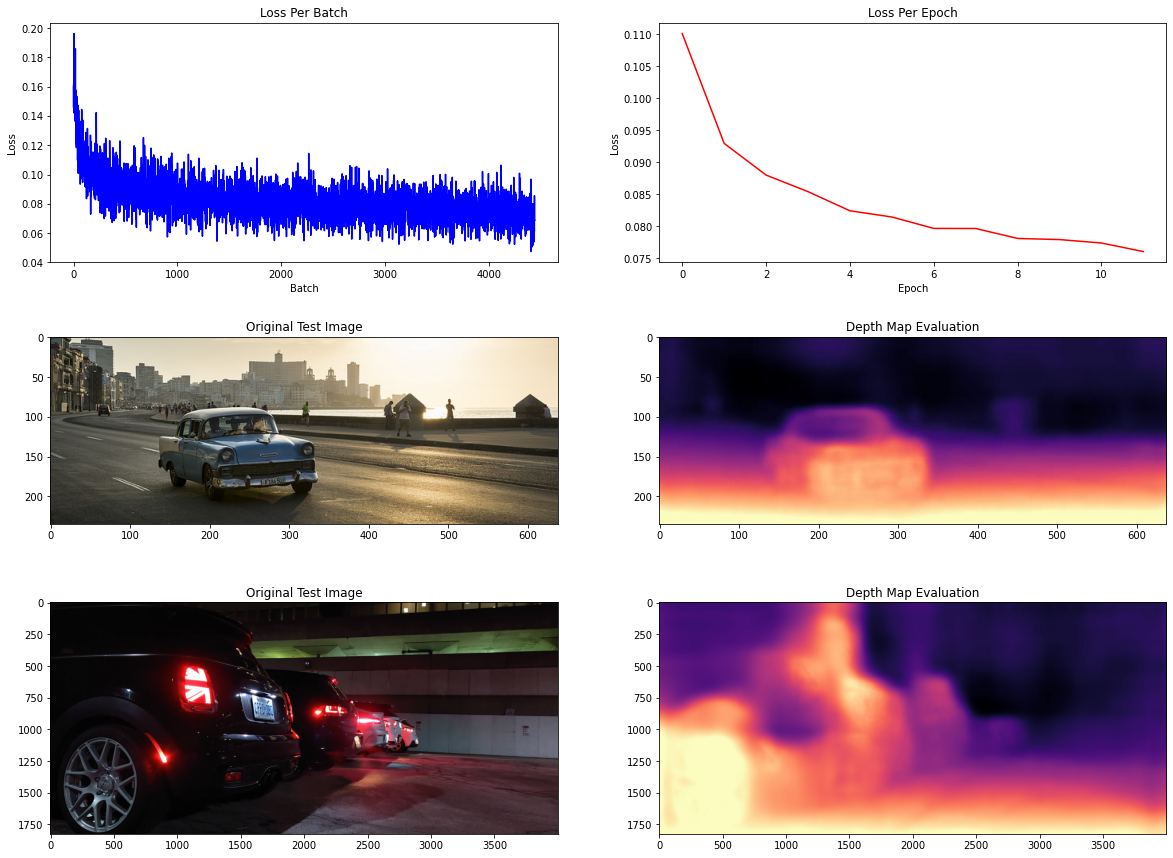

In [83]:
import matplotlib.pyplot as plt
# Batch loss
batch_losses = np.copy(train.losses)
batch_count = len(batch_losses) // train.epoch_max
print("# batches in epoch: {}".format(batch_count))
epoch_losses = []
for b in range(12):
    start = b*batch_count
    end = ((b+1)*batch_count) - 1
    # print("{}, {}".format(start, end))
    epoch_losses.append(np.average(batch_losses[start:end]))

plt.figure(1, figsize=(20,15))
plt.subplot(321)
plt.plot(range(len(batch_losses)), batch_losses, 'b')
plt.title("Loss Per Batch")
plt.xlabel("Batch")
plt.ylabel("Loss")

plt.subplot(322)
plt.plot(range(len(epoch_losses)), epoch_losses, 'r')
plt.title("Loss Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

test_image = pil.open("monodepth2/assets/test_image.jpg")
plt.subplot(323)
plt.imshow(test_image)
plt.title("Original Test Image")

test_image = pil.open("monodepth2/assets/test_image_disp.jpeg")
plt.subplot(324)
plt.imshow(test_image)
plt.title("Depth Map Evaluation")

test_image = pil.open("monodepth2/assets/alexa_cars.jpg")
plt.subplot(325)
plt.imshow(test_image)
plt.title("Original Test Image")

test_image = pil.open("monodepth2/assets/alexa_cars_disp.jpeg")
plt.subplot(326)
plt.imshow(test_image)
plt.title("Depth Map Evaluation")

plt.show()


In [55]:
! du -cs --block-size=M test_model
! zip test_model.zip test_model/*

# from google.colab import files
# files.download("/content/test_model.zip")
! cp test_model.zip "gdrive/MyDrive/CS484_Models/test_20e_12b_depth_bigger_data.zip"

216M	test_model
216M	total
  adding: test_model/adam.pth (deflated 8%)
  adding: test_model/depth.pth (deflated 8%)
  adding: test_model/encoder.pth (deflated 7%)
  adding: test_model/losses.txt (deflated 56%)
  adding: test_model/pose_encoder.pth (deflated 7%)
  adding: test_model/pose.pth (deflated 9%)


In [56]:
! python monodepth2/export_gt_depth.py --data_path kitti_data --split eigen
! python monodepth2/evaluate_depth.py --data_path kitti_data --load_weights_folder /content/test_model --eval_stereo

Exporting ground truth depths for eigen
Saving to eigen
-> Loading weights from /content/test_model
-> Computing predictions with size 640x192
-> Evaluating
   Stereo evaluation - disabling median scaling, scaling by 5.4

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.106  &   1.461  &   5.988  &   0.221  &   0.882  &   0.943  &   0.967  \\

-> Done!


# References

[1] https://arxiv.org/pdf/1806.01260.pdf

[2] https://arxiv.org/pdf/1511.08861.pdf